<a href="https://colab.research.google.com/github/Bensmail-anis/Building-a-GPT-Inspired-Transformer-from-Scratch/blob/main/notebooks/Detailed_Explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building mini-GPT from scratch

This notebook explores training a GPT-based inspired language model to captures the writing style and speech patterns of characters from Classroom of the Elite, a well-known light novel series, leveraging a dataset containing 7,000 pages (5.5 million characters) from the novels.

Inspired by the groundbreaking "Attention Is All You Need" paper, and by utilizing self-attention mechanisms,the model learns intricate linguistic patterns, character dialogues, and narrative structures, capturing the essence of the original text. Unlike traditional recurrent models, GPT (Generative Pre-trained Transformer) processes text in parallel, making it highly efficient in understanding long-range dependencies and contextual relationships.

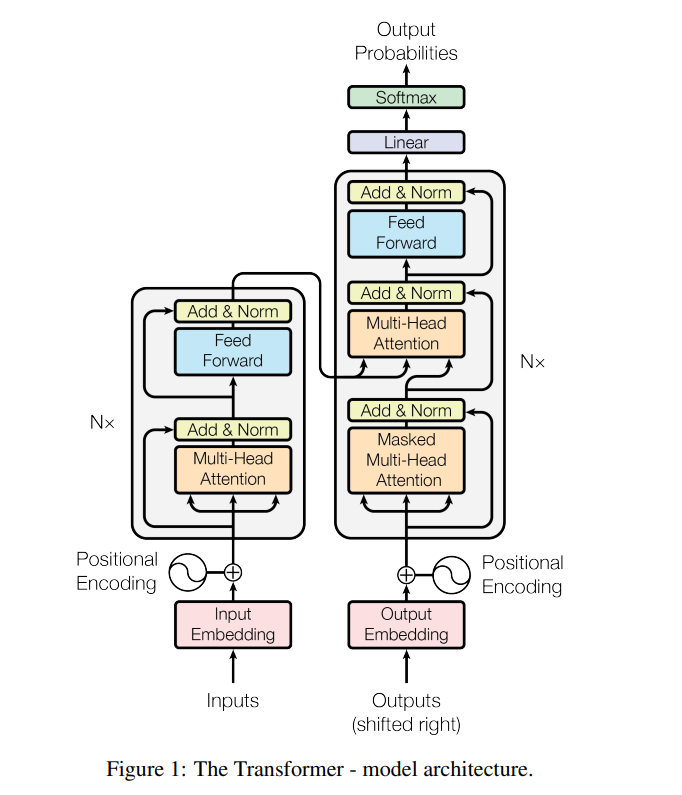

# Dataset Overview and Character Analysis
In this section, we load the Classroom of the Elite novel dataset, which consists of approximately 5.5 million characters across 7,000 pages. By reading the text file, we gain access to the raw content, including dialogues, narrative structures, and writing style. We then analyze the unique character set present in the dataset, determining the vocabulary size based on distinct characters. This step is crucial for tokenization and model training, as it helps define the input space for our language model.

In [18]:
with open("/content/Classroom of the Elite novels 1st year.txt" , "r" , encoding='utf-8') as f :
  text = f.read()

In [23]:
len(text)

5359238

In [24]:
print(text[:1000])

Chapter 1: 
The Structure of 
Japanese Society 


I know this is kind of sudden, but, please, it will only take a moment. I 


want your honest opinion. 
Are people equal or not? 


A proper society will constantly strive for equality. There are those 
who clamor for men and women to always be considered equal. As a result, 
we raised the employment rate for women, we made specialized subway cars 
only for women. Sometimes, women will even argue over the order of names 
in a family register. The public opinion of people with disabilities has also 
changed. We’re now told that we should not use the term “disabled people” 
when referring to them, so as not to discriminate. Nowadays, children are 
taught that all people are created equal. 


But is that true? I have my doubts. If men and women have different 
abilities, then their roles should also differ. People with disabilities are still 
disabled, no matter what polite euphemisms you use. No matter how you try 
to avert your eyes, the

# Character Encoding and Tokenization
To train our GPT model on Classroom of the Elite, we begin by encoding the text at the character level. The dataset contains 106 unique characters, including letters, punctuation, and special symbols. We establish a basic mapping for the moment between characters and integers, allowing us to convert text into numerical format for efficient processing. Using this mapping, we define an encoder (to transform text into sequences of integers) and a decoder (to reconstruct text from encoded data). Finally, we store the encoded dataset as a PyTorch tensor, preparing it for model training. This numerical representation is essential for feeding data into the Transformer architecture.

In [25]:
#unique characters in the dataset
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]_abcdefghijklmnopqrstuvwxyz{|}~¥«®°»é—‘’“”€
106


In [27]:
#mapping from characters to integers , basic tokenization for the moment
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[71, 72, 72, 1, 83, 71, 68, 81, 68]
hii there


In [28]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([5359238]) torch.int64
tensor([ 36,  71,  64,  79,  83,  68,  81,   1,  18,  27,   1,   0,  53,  71,
         68,   1,  52,  83,  81,  84,  66,  83,  84,  81,  68,   1,  78,  69,
          1,   0,  43,  64,  79,  64,  77,  68,  82,  68,   1,  52,  78,  66,
         72,  68,  83,  88,   1,   0,   0,   0,  42,   1,  74,  77,  78,  86,
          1,  83,  71,  72,  82,   1,  72,  82,   1,  74,  72,  77,  67,   1,
         78,  69,   1,  82,  84,  67,  67,  68,  77,  13,   1,  65,  84,  83,
         13,   1,  79,  75,  68,  64,  82,  68,  13,   1,  72,  83,   1,  86,
         72,  75,  75,   1,  78,  77,  75,  88,   1,  83,  64,  74,  68,   1,
         64,   1,  76,  78,  76,  68,  77,  83,  15,   1,  42,   1,   0,   0,
          0,  86,  64,  77,  83,   1,  88,  78,  84,  81,   1,  71,  78,  77,
         68,  82,  83,   1,  78,  79,  72,  77,  72,  78,  77,  15,   1,   0,
         34,  81,  68,   1,  79,  68,  78,  79,  75,  68,   1,  68,  80,  84,
         64,  75,   1,  78,  8

# Training Data Preparation and Contextual Learning
To train our GPT model, we first split the dataset into 90% training and 10% validation data. Since the Transformer processes fixed-length sequences, we start for the moment to define a context window (block size = 8), where the model predicts the 9th character based on the previous 8 characters. We ensure that the model does not receive more input characters than the block size to maintain efficient training.

We then generate mini-batches to train the model in parallel, allowing it to learn multiple sequences simultaneously. By shifting the input by one position, the model learns character-level dependencies, predicting the next character based on its context. This step is crucial for building long-range dependencies and improving text coherence in the generated output.

In [29]:
# We don't want a perfect memorization of that exact dataset
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [30]:
# if the block size is 8 , we use that in context to predict the 9th character which is block_size + 1
block_size = 8
train_data[:block_size+1]
# The transformer must not recieve a number of inputs characters bigger than the block size

tensor([36, 71, 64, 79, 83, 68, 81,  1, 18])

In [31]:
x = train_data[:block_size]
y = train_data[1:block_size+1]#offset by 1 , the 1 is the prediction for the 0th character
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([36]) the target: 71
when input is tensor([36, 71]) the target: 64
when input is tensor([36, 71, 64]) the target: 79
when input is tensor([36, 71, 64, 79]) the target: 83
when input is tensor([36, 71, 64, 79, 83]) the target: 68
when input is tensor([36, 71, 64, 79, 83, 68]) the target: 81
when input is tensor([36, 71, 64, 79, 83, 68, 81]) the target: 1
when input is tensor([36, 71, 64, 79, 83, 68, 81,  1]) the target: 18


In [32]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}") # The batches will be fed into the transformers , it will simultaneously process them and lookup to the target to predict

inputs:
torch.Size([4, 8])
tensor([[76, 65, 75, 72, 77, 70,  1, 64],
        [ 0, 86, 72, 83, 71,  1, 76, 88],
        [83, 82,  1, 64, 77,  1,  0, 72],
        [66, 74, 68, 67,  1, 84, 79,  1]])
targets:
torch.Size([4, 8])
tensor([[65, 75, 72, 77, 70,  1, 64, 82],
        [86, 72, 83, 71,  1, 76, 88,  1],
        [82,  1, 64, 77,  1,  0, 72, 81],
        [74, 68, 67,  1, 84, 79,  1, 83]])
----
when input is [76] the target: 65
when input is [76, 65] the target: 75
when input is [76, 65, 75] the target: 72
when input is [76, 65, 75, 72] the target: 77
when input is [76, 65, 75, 72, 77] the target: 70
when input is [76, 65, 75, 72, 77, 70] the target: 1
when input is [76, 65, 75, 72, 77, 70, 1] the target: 64
when input is [76, 65, 75, 72, 77, 70, 1, 64] the target: 82
when input is [0] the target: 86
when input is [0, 86] the target: 72
when input is [0, 86, 72] the target: 83
when input is [0, 86, 72, 83] the target: 71
when input is [0, 86, 72, 83, 71] the target: 1
when input is [0,

In [33]:
print(xb) # our input to the transformer

tensor([[76, 65, 75, 72, 77, 70,  1, 64],
        [ 0, 86, 72, 83, 71,  1, 76, 88],
        [83, 82,  1, 64, 77,  1,  0, 72],
        [66, 74, 68, 67,  1, 84, 79,  1]])


# Bigram Language Model vs. Transformer Models: A Comparative Analysis
Traditional Bigram Models
A bigram model is a simple Markov Chain-based approach to language modeling where the probability of a word depends only on the previous word. This method works by constructing a transition matrix based on observed word-pair frequencies in training data. The Bigram Language Model implemented here follows a similar concept but operates at the character level instead of words.


The model only looks at the immediate previous token, which severely restricts its ability to capture long-range dependencies.
Example: In the sentence "The cat sat on the mat.", a bigram model may only learn the probability of "sat" following "cat" but won’t understand the connection between "mat" and "cat".
Poor Generalization:

The model struggles with generating meaningful text beyond a few tokens, as seen in our generated output:
"Ika inde tobed, IP“Ho s ck.. g d Jperou toucoureve."
This happens because the model does not build a semantic representation of text.
High Perplexity (Loss Value):

The cross-entropy loss started at around 5.1199, which is worse than the theoretical starting best-case scenario of -log(1/106) ≈ 2.02


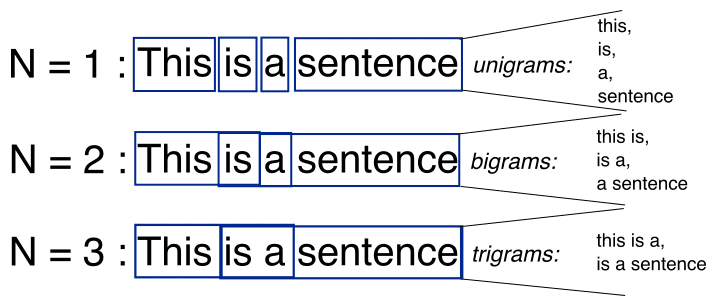

- token_embedding_table acts as a lookup mechanism:
Each token index maps to a corresponding row in a matrix of shape (vocab_size, vocab_size).
Instead of learning continuous vector representations like in transformer models, this embedding table learns direct mappings from indices to logits

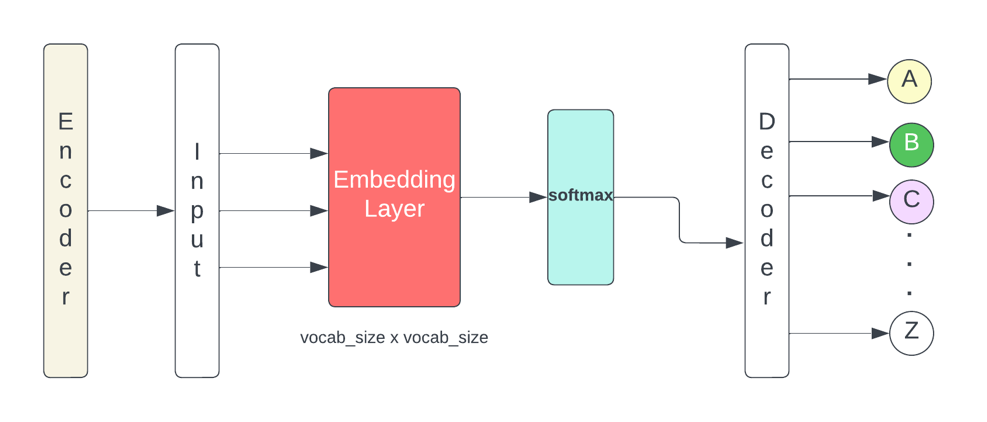

In [34]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C) , when we pass an idx here , it is going to refer to the embedding table , so it takes the corresponding row to the index , Pytorch will arrange this into (Batch=4 , time=8 ,channels=65) , it accepts as input (batch , sample)
        # logits are logically the score of the next character in the sequence
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C) # Because Pytorch cross_entropy expect (minibatch,C) as dimension , we have to reshape
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C) , -1 because for each batch , the prediction will be based on the last element
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1) #we sample one because we are going to have a single prediction to what comes next
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1) , we concatenate at the level of dimension 1 where we concat the predicted character to his context
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss) # talk that our loss is not that good as first try must have , since 4.89 > -log(1/65) = 4.17

print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


torch.Size([32, 106])
tensor(5.1199, grad_fn=<NllLossBackward0>)

Uh[’I¥uS6°rM*K3I‘L:Ot8Ktb?)rD*ZLI!%I:An,"“2<yO_KmzH|=<€Ry:8t|4*EkISw=whuv ,)K8JDUDO+9} ESqv#0@yN_+{2


- Shape Transformation: (B, T) → (B, T, C) :
   - Before embedding lookup: idx is of shape (B, T), where:
       - B = batch_size (e.g., 4)
       - T = sequence_length (e.g., 8)

   -After embedding lookup: logits becomes (B, T, C), where:
       
       - C = vocab_size (e.g., 106)

This transformation occurs because each token in idx gets mapped to a corresponding C-dimensional vector.

- Why do we reshape before cross_entropy ?

PyTorch's cross_entropy expects a (batch_size, num_classes) input.
Since our original shape is (B, T, C), we reshape it to (B*T, C) to match the expected format.
Targets are reshaped from (B, T) → (B*T,) to match the corresponding logits.

In [35]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

AdamW optimizer is used, which improves upon standard Adam by adding better weight decay regularization.

In [36]:
batch_size = 32
for steps in range(10000): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())


2.456510305404663


The loss improved to 2.4565, indicating the model is starting to learn.

In [37]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))



Ika inde tobed, 

IP“Ho s ck.. g d Jperou toucoureve. 

Hermoraly tedun t wora Keeme 



rthagim Sup4: It jumag Shaucotoosfyou cem icoorokenad hy t 

I okngund. orouss endeansave wof f m Anoup oug s 




Cld. y. g trme ad o ny. a 5*” Thenalous. cer://AGou. 
Sh qusilyod tuP»5 f kirneck wo advere thard cidinglerf s rsper s.. Hoo. 
“Shou s 
I 




Maprd, hain y es, goug I wanghing tou n fie hadsthey t de, 
con aduirkall to tollin ed ct’rplitemenered. t€guno n ina-bullinonghouthul obeseme We hiourX


| Feature | Bigram Model | Transformer Model (GPT) |
| --- | --- | --- |
| **Context Window** | Only 1 token (previous) | Full sequence (Self-Attention) |
| **Representation** | Token-based mapping (logits) | Continuous embeddings (word vectors) |
| **Long-term Memory** | No (Markov assumption) | Yes (Positional Encoding & Self-Attention) |
| **Performance** | High perplexity (low-quality text) | Low perplexity (meaningful text) |
| **Training Complexity** | O(N) (linear) | O(N²) (quadratic due to attention) |

# **Step Towards Self-Attention: Mean Aggregation Trick**



In [1]:
# consider the following toy example:
import torch
torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [2]:
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)


In [3]:
x[0]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [4]:
xbow[0]

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

In our transition to self-attention, we first explore a simple way to aggregate past tokens: computing the **mean of all previous tokens** at each position. This introduces a basic form of contextualization where each token's representation incorporates information from past tokens.

#### **Understanding the Transformation of x to xbow**

*   x is initially a random tensor of shape **(B, T, C)**, representing our batch of sequences.
    
*   We construct xbow, which will store the **cumulative mean** of x across time steps.
    
*   The loop iterates through each batch and computes the **mean of all previous tokens** up to the current position.
    

#### **Key Observations**

1.  Each x\[b, t\] (token at time t) is replaced by the average of all tokens from 0 to t.
    
2.  This operation makes xbow\[b, t\] **context-dependent**—it contains information from previous tokens but treats them equally.
    
3.  The output shape remains **(B, T, C)**, but now every token is a function of all preceding tokens.
    

#### **Why is this Important?**

*   This introduces a **form of dependency** across tokens, unlike the bigram model, where predictions are based solely on a single preceding token.
    
*   However, this is **not yet self-attention** because all previous tokens are treated with equal importance.
    
*   The next step is to assign **learnable weights** to different tokens so that the model can decide which tokens are more important for each position.

# Weighted Aggregation with Matrix Multiplication

We previously implemented a **mean aggregation** using nested loops, where each time step t took the mean of all previous values x\[b,i\] (i.e., cumulative averaging). Now, we introduce a **more efficient** approach using **matrix multiplication**.

#### 1\. Understanding torch.tril()

We first construct a lower triangular matrix using torch.tril():

```python
torch.tril(torch.ones(3, 3))  
```

This creates a **causal mask** that ensures each position in the sequence only attends to itself and previous positions.





In [5]:
torch.tril(torch.ones(3, 3))

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

#### 2\. Weighted Aggregation via Matrix Multiplication

Instead of looping, we use matrix multiplication to efficiently compute the cumulative mean aggregation:

```python  
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True) # Normalizing rows  
```

Here:

*   wei is a **lower triangular matrix**, meaning each row contains only ones up to the diagonal.
    
*   The division by wei.sum(1, keepdim=True) ensures **each row sums to 1**, creating a **cumulative averaging mask**.
    

Now, instead of looping over time steps, we perform:

```python  
xbow2 = wei @ x
```   

*   **Shape transformation:** (T,T)×(B,T,C)⇒(B,T,C)
    
*   **PyTorch broadcasting:** Automatically applies the operation over the batch dimension.
    

In [6]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b # Look to the weighted aggregation gotten
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [7]:
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)


#### 3\. Comparing Both Approaches

To verify correctness, we compare our **loop-based** and **matrix-based** implementations:

```python  
torch.allclose(xbow, xbow2)  
```  

Both produce the same results, confirming correctness.

#### 4\. Key Observations:

*   **Matrix multiplication is significantly faster** than looping over time steps.
    
*   **Causal structure is preserved**, as each position only depends on previous tokens.
    
*   This approach lays the **foundation for self-attention**, where weights are **learned** instead of being fixed.
    

This sets the stage for **self-attention**, where instead of a simple **mean**, we use **learnable attention weights** to determine how much focus each token should give to others.

In [8]:
# version 2: using matrix multiply for a weighted aggregation "more efficient than the loops"
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (T, T) @ (B, T, C) ---->(B, T, T) @ (B, T, C) ----> (B, T, C) , pytorch will create the batch  dimension for wei


In [9]:
xbow.shape , xbow2.shape

(torch.Size([4, 8, 2]), torch.Size([4, 8, 2]))

In [10]:
xbow[0] , xbow2[0]

(tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]),
 tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]))

# Introducing Softmax for Weighted Aggregation

In the previous step, we used **simple averaging** to aggregate information from past tokens. Now, we introduce **Softmax**, which is a key ingredient in **self-attention**.

### 1\. Understanding the Role of Softmax

Softmax is used to convert **raw scores** into a **probability distribution**, ensuring that the weights sum to 1 while emphasizing certain values more than others.

Instead of using a simple mean, we now compute:

attention weights=Softmax(W)

where:

*   W is the lower triangular matrix with -inf in places where no attention is allowed.
    
*   Applying exp() to these values ensures that only allowed positions contribute to the final aggregation.
    

### 2\. Applying Softmax in Code

#### **Step 1: Construct the Causal Mask**

```python
tril = torch.tril(torch.ones(T, T))  
wei = torch.zeros((T, T))  # Initialize weight matrix
wei = wei.masked_fill(tril == 0, float('-inf'))  # Mask future values
```

This ensures that tokens can only attend to previous ones.

#### **Step 2: Apply Softmax**

```python
wei = F.softmax(wei, dim=-1)`
```
*   The softmax function applies **exponential scaling and normalization**.
    
*   Since exp(-inf) = 0, positions that were masked (future positions) get a weight of **0**.
    

### 3\. Observing the Weighted Aggregation

After applying softmax, wei looks like this:
```python
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

```
Each row now **smoothly distributes attention** across valid positions while ensuring a **causal structure**.

### 4\. Computing the Weighted Aggregation

We now use:
```python
xbow3 = wei @ x
```
*   This performs **softmax-weighted aggregation** instead of simple averaging.
    
*   Unlike **mean pooling**, Softmax allows **learned attention scores** later on.
    

### 5\. Why This Matters for Self-Attention

This step is **crucial** because:

*   **Softmax ensures that attention scores sum to 1**, making them interpretable.
    
*   This mechanism generalizes to **learned attention** by replacing fixed weights with **query-key scores**.
    
*   We are now **one step away** from full **self-attention**.
    

### Next Steps

The next improvement will involve:

1.  **Introducing Queries, Keys, and Values** instead of fixed weights.
    
2.  **Computing similarity scores dynamically** instead of relying on a predefined mask.
    

This will **fully transition into self-attention**, the core of the Transformer architecture. 🚀

In [39]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x


False

In [41]:
tril = torch.tril(torch.ones(T, T))
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [43]:
wei = wei.masked_fill(tril == 0, float('-inf'))
wei

tensor([[1.0000,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.5000, 0.5000,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.3333, 0.3333, 0.3333,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.2500, 0.2500, 0.2500, 0.2500,   -inf,   -inf,   -inf,   -inf],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000,   -inf,   -inf,   -inf],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667,   -inf,   -inf],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429,   -inf],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [44]:
wei = F.softmax(wei, dim=-1)  # the using of exp() then dividing to the sum of exps , exp(-inf)=0 , you can see clearly the aggregation now when you multiply with x
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [ ]:
# bu actionly , we don't want this type of uniform distribution , we want a form of data dependancy , a vowel can look for a consonant , so i want to gather an information from in the past , but i want to do it in data dependant way

# 🔹 **Key Idea**: Learnable Attention Weights

Previously, the attention weights were uniform (1/n for previous tokens), meaning every past token contributed equally. However, self-attention solve this by :

1.  Each token generates:
    
    *   A **Key**: Represents "what information I contain."
        
    *   A **Query**: Represents "what information I am looking for."
        
    *   A **Value**: Represents "what I contribute to the final aggregation."
        
2.  **Affinity Calculation** (Dot Product between Queries and Keys):
    
    *   The wei = q @ k.T step computes how well a token’s **query** aligns with the **keys** of all other tokens.
        
    *   If the dot product is high, it means the token finds another token **relevant**, and it should attend to it more.
        
3.  **Masking for Causal Attention**:
    
    *   The masked\_fill(tril == 0, float('-inf')) ensures each token only attends to itself and past tokens.
        
    *   The softmax() normalizes the scores into a probability distribution.
        
4.  **Weighted Aggregation of Values**:
    
    *   The **values** are aggregated based on these learned attention weights.
        
    *   out = wei @ v means each token selectively gathers information from the past in a data-dependent way.

In [15]:
# the way self-attention solve this problem : every token will emit 2 vectors , a key("What do i contain") and a query("what am i looking for ")
# So we got the dot product(wei) between the keys and querys , i am a token , my query dot product with all keys of other tokens , if the key and query are aligned , they will interact with high amount
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16) , since the input shape of key is C and output shape is head_size
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T) , the communication happens here

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf')) # If i am the fifth token , i will not want to aggragate anything from the sixth token and more
wei = F.softmax(wei, dim=-1)

v = value(x) # v is the element we aggregate instead of the raw x
out = wei @ v # After the value , the communication is confirmed here again , each token will confirm his partner that he has a good amount with him
# Hi i am the token , my private information are in x , here is what i have "the key" and here is what i am looking for "query" and if you find anything interesting here is what i will communicate to you "value"
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

In [16]:
wei[0] # in last row for example , maybe a good affinity between the 4th token and 8th ?

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate "in a case like sentiment analysis for example". This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

### 🔹 **Next Step: Scaling & Multi-Head Attention**

This implementation can be improved further by:

*   **Scaling dot product attention**: Normalize wei = (q @ k.T) / sqrt(head\_size) to prevent large values from dominating softmax.
    
*   **Multi-Head Attention**: Instead of a single attention mechanism, use **multiple heads** with different query/key projections.

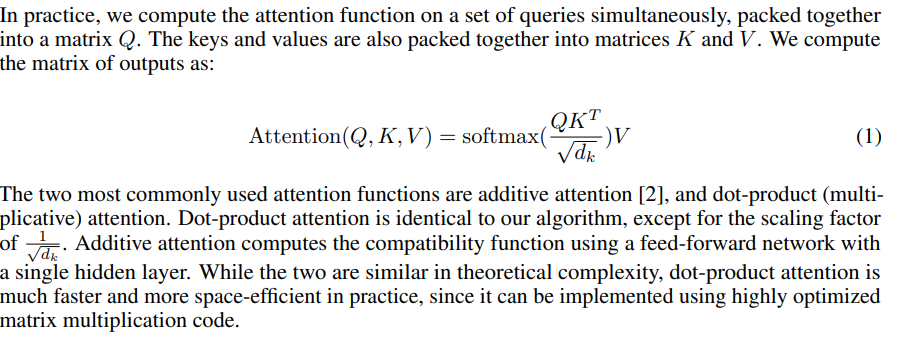

In [22]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) # * head_size**-0.5 , without scaling

In [23]:
k.var(),q.var(),wei.var()

(tensor(1.0966), tensor(0.9416), tensor(16.1036))

In [24]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [25]:
k.var(),q.var(),wei.var()

(tensor(1.0104), tensor(1.0204), tensor(1.1053))

The key idea behind Scaled Dot-Product Attention is to prevent softmax from overly sharpening the attention distribution when dealing with large values , by getting a lower wei variance , we can see that happens in those two examples when we multiply the same vector with 8

In [27]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [26]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot , we dont want this peak so a token will pick only one token in initialization

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

# Layer Normalization: Feature-Wise Normalization for Stable Training

Layer normalization (LayerNorm) is a normalization technique that operates across the feature dimension of each individual sample in a batch, ensuring stable learning dynamics, especially in sequential models like Transformers. Unlike Batch Normalization, which normalizes across the batch dimension, LayerNorm computes the mean and variance for each sample independently across its feature dimension. Given an input x of shape (B, C), where B is the batch size and C is the number of features, the normalization process involves computing the mean (B, 1) and variance (B, 1) across the last dimension. The standardized output is obtained by subtracting the mean and dividing by the standard deviation, with a small epsilon (eps) added to avoid numerical instability. This produces a transformed tensor of shape (B, C), preserving the original feature dimension. Finally, trainable parameters gamma (scaling) and beta (shifting), both of shape (C,), allow the model to learn an optimal transformation of the normalized data. This method ensures consistent activation distributions, improves gradient flow, and is particularly useful in architectures where batch statistics are unreliable, such as in RNNs and Transformers.

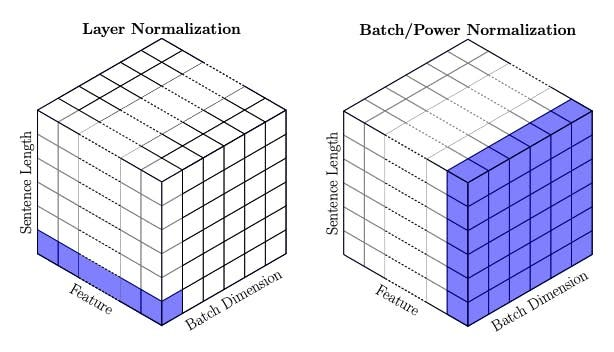

In [11]:
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # it normalizes rows instead of columns , the mean calculated over the last dimension
    xvar = x.var(1, keepdim=True) #
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [12]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

(tensor(0.1469), tensor(0.8803))

In [13]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

(tensor(-9.5367e-09), tensor(1.0000))

# Self-Attention Head: Context-Aware Information Extraction
A self-attention head is a fundamental unit in attention-based architectures, responsible for dynamically weighting input tokens based on their contextual importance. Given an input x of shape (B, T, C), where B is the batch size, T is the sequence length (time steps), and C is the embedding dimension, the mechanism first maps each token into three learned representations: keys (k), queries (q), and values (v), all of shape (B, T, hs), where hs is the head size. The attention scores are computed as the scaled dot product between queries and transposed keys, yielding an interaction matrix wei of shape (B, T, T), representing token-to-token relationships. A lower-triangular mask (tril) ensures causal attention by preventing each token from attending to future tokens. After applying the softmax operation for normalization and dropout for regularization, these weights are used to aggregate values, producing an output of shape (B, T, hs). This mechanism enables each token to extract relevant information from past tokens dynamically, allowing models to capture dependencies and enhance sequence representations.

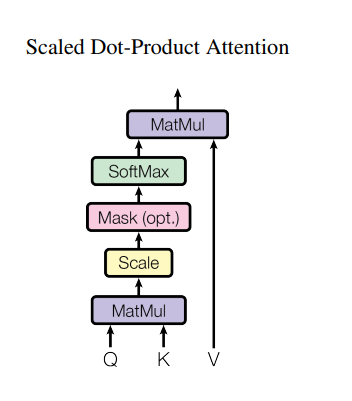

In [17]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

# Multi-Head Attention: Enhancing Representation Diversity
Multi-head attention extends the self-attention mechanism by running multiple independent attention heads in parallel, each learning different relational patterns in the input sequence. Given an input x of shape (B, T, C), where B is the batch size, T is the sequence length, and C is the embedding dimension, num_heads separate self-attention heads process the input independently, each producing an output of shape (B, T, hs), where hs is the head size. The outputs from all heads are concatenated along the last dimension, forming a tensor of shape (B, T, num_heads * hs), which is then projected back to the original embedding size C using a linear layer. This projection ensures that information from multiple attention perspectives is combined effectively. The dropout layer adds regularization, preventing overfitting. By attending to different aspects of the input simultaneously, multi-head attention improves the model’s ability to capture complex dependencies across tokens.

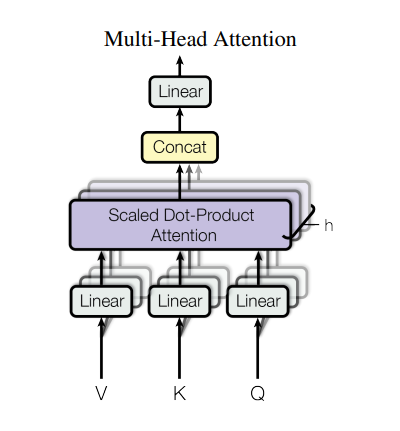

In [18]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

# Feed-Forward Network: Expanding and Refining Representations
The feed-forward network (FFN) acts as a transformation layer applied independently to each token's embedding. It consists of two linear layers with a hidden expansion: the first maps the input of size (B, T, C) to a higher-dimensional space (B, T, 4C), allowing the model to learn richer feature representations. The ReLU activation introduces non-linearity, helping to capture complex interactions. The second linear layer projects the output back to (B, T, C), ensuring the token embedding size remains consistent. Dropout is applied for regularization, reducing overfitting. This structure enables the model to refine token-wise information beyond what is captured by attention mechanisms.

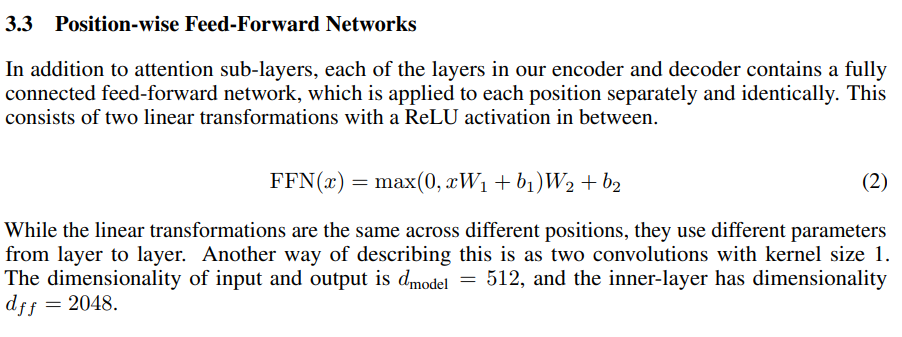

In [19]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

# Transformer Block: Combining Communication and Computation
The Transformer block is the fundamental unit of the Transformer model, designed to process sequential data efficiently. It consists of two main components: Multi-Head Self-Attention (MHA) and a Feed-Forward Network (FFN), each followed by Layer Normalization. The input tensor of shape (B, T, C) is first normalized and passed through the MHA module, allowing each token to attend selectively to others. A residual connection ensures stable gradient flow. Next, the output undergoes another normalization step before being fed into the FFN, which expands and refines the token representations. Another residual connection stabilizes updates, ensuring effective learning and feature transformation.

In [20]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


#Token Generation with Self-Attention
We begins with two embedding layers: a token embedding table (mapping words to dense representations of shape (B, T, C)) and a position embedding table (providing positional information of shape (T, C)). These embeddings are summed to form contextual token representations, which are processed by multiple Transformer blocks. Each block contains multi-head self-attention for contextual understanding and a feed-forward network for feature transformation. A final layer normalization refines the output before passing it to the logits projection layer (lm_head), which predicts the next token probability distribution of shape (B, T, vocab_size). The generate method autoregressively samples new tokens, iteratively extending the sequence while maintaining coherence.

In [21]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


## Notes :
### Pre-Layer Normalization Before Attention and Feedforward
We chose to apply Layer Normalization before Multi-Head Attention and Feedforward layers rather than after, deviating slightly from the original Transformer paper. This adjustment, often referred to as Pre-Norm, helps stabilize training, especially in deeper architectures, by ensuring that each sub-layer operates on well-conditioned inputs. Unlike Post-Norm, where normalization happens after residual connections (potentially leading to exploding activations), Pre-Norm avoids such issues and enables more effective gradient flow, making training more stable and efficient.

### Missing Cross-Attention: Why It’s Not Implemented Yet
The model currently lacks Cross-Attention, which is typically used in architectures like encoder-decoder transformers (e.g., in translation tasks). We haven't implemented it yet because our current setup is a decoder-only model (GPT-style), where the network generates sequences based solely on prior tokens. Cross-attention would only be necessary if we needed to condition the generation on an external input sequence, such as in question-answering or multimodal tasks.

# The full picture

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F


batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 15000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2


torch.manual_seed(1337)

with open('/content/Classroom of the Elite novels 1st year.txt', 'r', encoding='utf-8') as f:
    text = f.read()


chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])


data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]


def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

model = GPTLanguageModel()
m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch('train')

    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

10.820458 M parameters
step 0: train loss 4.7432, val loss 4.7415
step 500: train loss 1.5570, val loss 1.5492
step 1000: train loss 1.2379, val loss 1.2496
step 1500: train loss 1.1334, val loss 1.1499
step 2000: train loss 1.0729, val loss 1.1086
step 2500: train loss 1.0364, val loss 1.0743
step 3000: train loss 1.0065, val loss 1.0559
step 3500: train loss 0.9839, val loss 1.0406
step 4000: train loss 0.9603, val loss 1.0320
step 4500: train loss 0.9490, val loss 1.0208
step 5000: train loss 0.9339, val loss 1.0191
step 5500: train loss 0.9223, val loss 1.0104
step 6000: train loss 0.9106, val loss 1.0016
step 6500: train loss 0.9014, val loss 0.9968
step 7000: train loss 0.8925, val loss 0.9908
step 7500: train loss 0.8832, val loss 0.9850
step 8000: train loss 0.8769, val loss 0.9889
step 8500: train loss 0.8679, val loss 0.9813
step 9000: train loss 0.8589, val loss 0.9794
step 9500: train loss 0.8537, val loss 0.9800
step 10000: train loss 0.8439, val loss 0.9712
step 10500: tr

In [2]:
torch.save(m.state_dict(), 'transformer_model_weights.pth')

In [3]:
# Encode the starting text
context = torch.tensor([[stoi[c] for c in "Ayanokoji"]], dtype=torch.long, device=device)
generated_text = model.generate(context, max_new_tokens=1000)
print(decode(generated_text[0].tolist()))

Ayanokoji and Hirata-kun had just earlier this 
obvious conversation. Or someone in the class, I’d liker to keep my upper 
group number of people. If so, we closed the classroom, participating apart that would 
not say any further thank. There was also a distance from Hirata, agreeing 
what we would do fine, too. 


“He’s all smart prints in tourname.” 


If I could easy play, that wouldn’t have been an exaly expulsion. After hearing 
the individual injury some exam, if the unathletic group had earned enough 
nothing, they couldn’t reset the discussion by being a figure in mostly 
believable in Kouenji’s own yen. His expression grew and handed over an 
decent stream. 


“When you’re with one tears ass a to-hearted secret you, what should I do?” 


Hirata more than our yaning defeated would probably recognize his other 


students, Ibuki wipe them in silence. 


“Well, I won’t do anything at the same. But this day, I’m just terrible. In 
addition to whatever you learn is to do this, I j

In [4]:
# Encode the starting text
context = torch.tensor([[stoi[c] for c in "time"]], dtype=torch.long, device=device)
generated_text = model.generate(context, max_new_tokens=1000)
print(decode(generated_text[0].tolist()))

time Ryuuen. I normally remembered. 


“My, see are reasonable if I take the impression on cuys. The fact that 
Kinoshita-san thinks to a seriously grow tough, ever since she loved junkling her 
wishes. She probably does get no satisfaction and even joking to me, 
Horikita-san. You have to be able to ulter.” 


“Tt’s an essential spot after a liar. Students who obediently formed a 
grudge, at high school who probably wants to come after getting in her 
time. Before they reached our own, her voices could et me through productions for her 
taking and emergency. I might instoal prombited her your conksure. 


“So I thought it would be impossible for you to nodkere if I 
ask you to say others. You’re in the middle of weetn, you know doing this.” 


Until I remembered that it had been caught more so tricklier to green together. 


“Dude, when she stoop it by making them on.” 

“Auh...ah... Huh? Why-what that is?” 


Airi, who was nothing more so fir of 
me, was something that Kiyotaka. didn